In [1]:
## Standard imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os
import json
import torch
import astroddpm
import tqdm.notebook as tqdm

## Relative imports
from astroddpm.runners import Diffuser, config_from_id, get_samples
from astroddpm.analysis.validationMetrics import powerSpectrum, minkowskiFunctional, basics
from astroddpm.analysis import overfitting_check
from astroddpm.utils.plot import check_nearest_epoch, plot_losses, check_training_samples, plot_comparaison, plot_and_save_lines, plot_and_save_line
from astroddpm.diffusion.dm import DiscreteSBM
from astroddpm.diffusion.stochastic.sde import DiscreteVPSDE, DiscreteSigmaVPSDE
from astroddpm.diffusion.models.network import ResUNet
import astroddpm.utils.colormap_custom 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
amin = - 6
amax = 6

MODEL_ID = 'DiscreteSBM_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_32'

In [3]:
placeholder_dm = DiscreteSBM(DiscreteVPSDE(1000), ResUNet())
diffuser = Diffuser(placeholder_dm)
diffuser.load(config=config_from_id(MODEL_ID), also_ckpt=True, for_training=True)
model = diffuser.diffmodel
power_spectrum_cmb = model.sde.power_spectrum

No model id found
Loading the diffuser from a config dict.
Loading the optimizer and scheduler states from the checkpoint, as well as previous training info. You should change the model id if you want to finetune the model.


Dummy Diffusion Model to check computations on pure gaussians

In [4]:
class Network_PS_from_Gaussian(torch.nn.Module):
    ''' Dummy diffusion network where the "dataset" is just colored noise and the diffusion process is white noise. '''
    def __init__(self, N, power_spectrum, beta_min = 0.1, beta_max = 20):
        super(Network_PS_from_Gaussian, self).__init__()
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.beta_0 = beta_min/N
        self.beta_T = beta_max/N
        self.betas = torch.linspace(self.beta_0, self.beta_T, N, dtype=torch.float32).to(device)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - self.alphas_cumprod)

        self.power_spectrum = power_spectrum ## Initial power spectrum
        self.config = {}
        self.in_c = 1
        self.sizes = [256]

    def forward(self, x, t):
        ## Return the modified score
        power_spectrum_t = (self.power_spectrum * (self.alphas_cumprod[t]).reshape(-1, 1, 1, 1) + (1 - self.alphas_cumprod[t].reshape(-1, 1, 1, 1)))
        return self.sqrt_one_minus_alphas_cumprod[t].reshape(-1, 1, 1, 1) * torch.fft.ifft2(torch.fft.fft2(x)/power_spectrum_t).real

class Network_PS_from_PS(torch.nn.Module):
    ''' Dummy diffusion network where the "dataset" is just colored noise and the diffusion process is also colored noise. '''
    def __init__(self, N, power_spectrum_0, power_spectrum_T, beta_min = 0.1, beta_max = 20):
        super(Network_PS_from_PS, self).__init__()
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.beta_0 = beta_min/N
        self.beta_T = beta_max/N
        self.betas = torch.linspace(self.beta_0, self.beta_T, N, dtype=torch.float32).to(device)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - self.alphas_cumprod)

        self.power_spectrum_0 = power_spectrum_0 ## Initial power spectrum
        self.power_spectrum_T = power_spectrum_T ## Final power spectrum

        self.in_c = 1
        self.sizes = [256]
        
        self.config = {}

    def forward(self, x, t):
        ## Return the modified score
        power_spectrum_t = (self.power_spectrum_0 * (self.alphas_cumprod[t]).reshape(-1, 1, 1, 1) + (1 - self.alphas_cumprod[t].reshape(-1, 1, 1, 1))*self.power_spectrum_T)
        return self.sqrt_one_minus_alphas_cumprod[t].reshape(-1, 1, 1, 1) * torch.fft.ifft2(torch.fft.fft2(x)*self.power_spectrum_T/power_spectrum_t).real

CMB from white noise

In [5]:
net = Network_PS_from_Gaussian(1000, power_spectrum_cmb)
sde = DiscreteVPSDE(1000)
model_cmb_from_white_noise = DiscreteSBM(sde, net)

In [6]:
samples = model_cmb_from_white_noise.generate_image(32)

100%|██████████| 1000/1000 [00:00<00:00, 2201.08it/s]


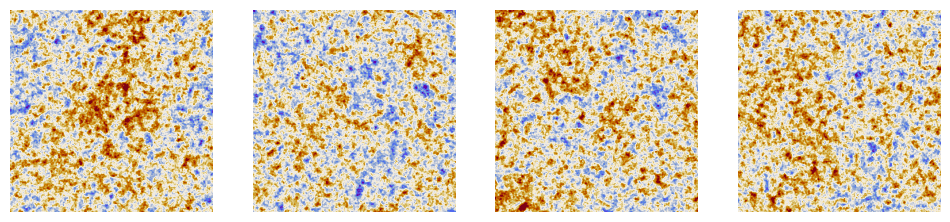

In [7]:
## Plot the first four images of gen (shape B, C=1, H, W)
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, ax in enumerate(axes):
    ax.imshow(samples[i, 0].detach().cpu(), cmap = 'cmb', vmin = -3, vmax = 3)
    ax.axis('off')

In [8]:
ll, pll, lls, gen = model_cmb_from_white_noise.log_likelihood(samples.detach(), initial_timestep=0, repeat=10)

100%|██████████| 1000/1000 [00:02<00:00, 442.45it/s]


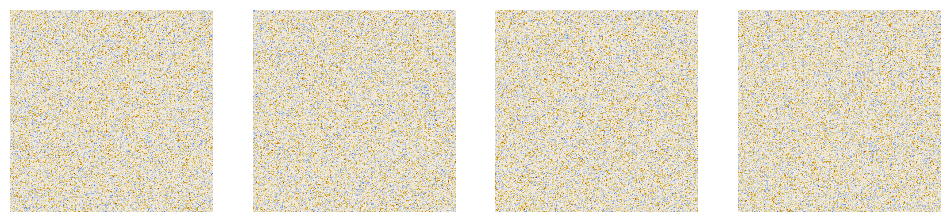

In [9]:
## Plot the first four images of gen (shape B, C=1, H, W)
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, ax in enumerate(axes):
    ax.imshow(gen[i, 0].detach().cpu(), cmap = 'cmb', vmin = -3, vmax = 3)
    ax.axis('off')

In [10]:
lllist = [ll[0].detach().cpu() for ll in lls]

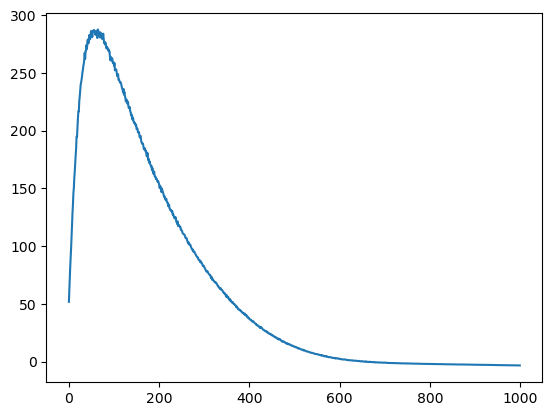

In [11]:
plt.plot(lllist)

In [12]:
(ll/256**2/np.log(2))

tensor([-0.6022, -0.6024, -0.6071, -0.6000, -0.5934, -0.5985, -0.5957, -0.6030,
        -0.6083, -0.5998, -0.6056, -0.5965, -0.6041, -0.6056, -0.5995, -0.5978,
        -0.6020, -0.6057, -0.5995, -0.6039, -0.6001, -0.5994, -0.6012, -0.6014,
        -0.5997, -0.6036, -0.6015, -0.5960, -0.5981, -0.6019, -0.5995, -0.6093],
       device='cuda:0', grad_fn=<DivBackward0>)

In [13]:
sde2 = DiscreteSigmaVPSDE(1000, net.power_spectrum)
sde2.prior_log_likelihood(samples)/256**2/np.log(2)

tensor([-0.6050, -0.6049, -0.6097, -0.6031, -0.5952, -0.6009, -0.5977, -0.6053,
        -0.6113, -0.6019, -0.6083, -0.5986, -0.6070, -0.6082, -0.6020, -0.6004,
        -0.6037, -0.6082, -0.6026, -0.6062, -0.6027, -0.6012, -0.6032, -0.6041,
        -0.6014, -0.6048, -0.6043, -0.5985, -0.6016, -0.6046, -0.6021, -0.6115],
       device='cuda:0')

CMB from CMB+white noise

In [33]:
net = Network_PS_from_PS(1000, torch.ones(256,256).to(device), power_spectrum_cmb)
sde = DiscreteSigmaVPSDE(1000, power_spectrum=(power_spectrum_cmb))
model_cmb_from_colored = DiscreteSBM(sde, net)

100%|██████████| 1000/1000 [00:00<00:00, 1645.26it/s]


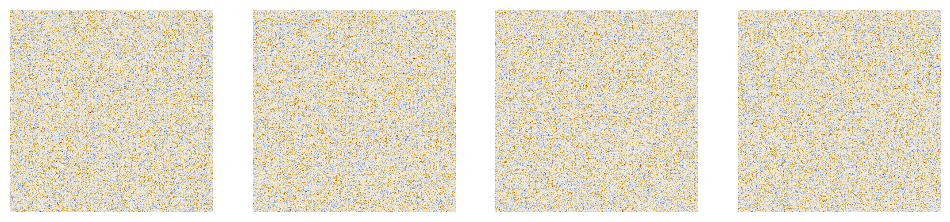

In [34]:
samples = model_cmb_from_colored.generate_image(32)
## Plot the first four images of gen (shape B, C=1, H, W)
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, ax in enumerate(axes):
    ax.imshow(samples[i, 0].detach().cpu(), cmap = 'cmb', vmin = -3, vmax = 3)
    ax.axis('off')

100%|██████████| 1000/1000 [00:02<00:00, 436.42it/s]


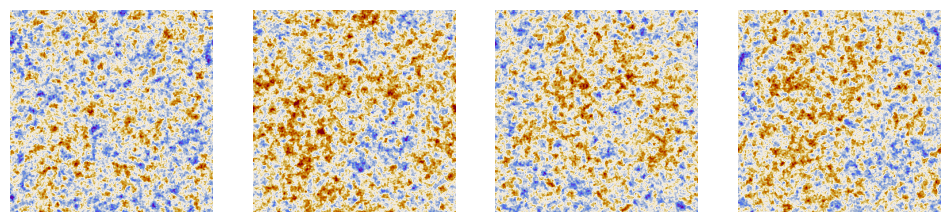

In [35]:
ll, pll, lls, gen = model_cmb_from_colored.log_likelihood(samples.detach(), initial_timestep=0, repeat=10)
## Plot the first four images of gen (shape B, C=1, H, W)
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, ax in enumerate(axes):
    ax.imshow(gen[i, 0].detach().cpu(), cmap = 'cmb', vmin = -3, vmax = 3)
    ax.axis('off')

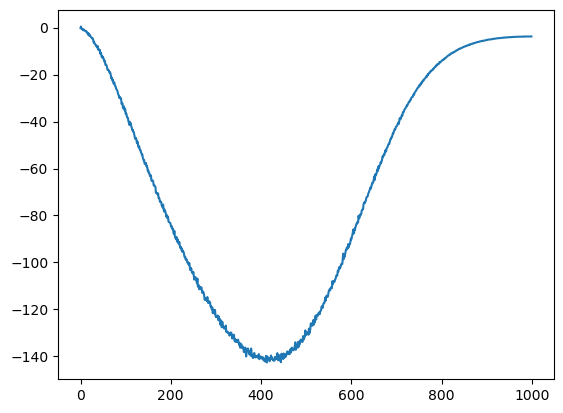

In [36]:
lllist = [ll[0].detach().cpu() for ll in lls]
plt.plot(lllist)

In [29]:
(ll/256**2/np.log(2))

tensor([-0.6041, -0.6007, -0.6034, -0.5991, -0.6005, -0.5981, -0.5946, -0.5958,
        -0.5983, -0.6008, -0.6029, -0.5961, -0.6008, -0.6021, -0.5994, -0.6019,
        -0.6017, -0.6058, -0.5957, -0.5995, -0.5980, -0.5981, -0.6012, -0.6049,
        -0.6028, -0.6034, -0.6003, -0.6027, -0.6016, -0.5991, -0.5971, -0.6008],
       device='cuda:0', grad_fn=<DivBackward0>)

In [31]:
sde2 = DiscreteSigmaVPSDE(1000, net.power_spectrum_0)
sde2.prior_log_likelihood(samples)/256**2/np.log(2)

tensor([-0.6056, -0.6022, -0.6058, -0.6011, -0.6023, -0.5994, -0.5959, -0.5967,
        -0.5999, -0.6026, -0.6056, -0.5971, -0.6027, -0.6037, -0.6016, -0.6043,
        -0.6039, -0.6084, -0.5972, -0.6010, -0.6008, -0.5995, -0.6033, -0.6068,
        -0.6047, -0.6057, -0.6018, -0.6045, -0.6043, -0.6011, -0.5980, -0.6034],
       device='cuda:0')